# Machine Learning  Optimization Notebook

In [2]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import seaborn as sns
from datetime import timedelta, datetime

dir = Path(r"S:\Fackler_OSS_364376\data\IRB-364376-v1-230215")

Load data frame and visualize class label distribution via a histogram

Text(0, 0.5, 'frequency')

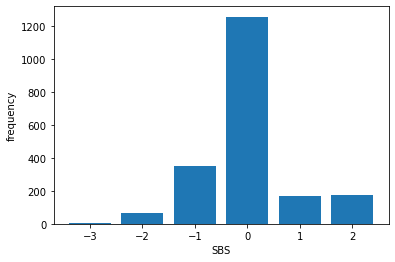

In [35]:
X = np.load('./DONOTPUSH/waveforms_60min.npy')
y = np.load('./DONOTPUSH/sbs_60min.npy')
ids = np.load('./DONOTPUSH/ids_60min.npy')

# shift SBS label: multiclass classifier needs labels to start from 0
labels, counts = np.unique(y, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xlabel('SBS')
plt.ylabel('frequency')

#### Visualize patient data

Observations:
- RR appears to have a lot of missing values (Note: missing valeus were replaced with extraneous value of -1)
- SpO2 mostly constant near 100
- HR appears elevated in oversedated patients

In [5]:
(undersed,) = np.where(y == 2)
(oversed,) = np.where(y == -2)

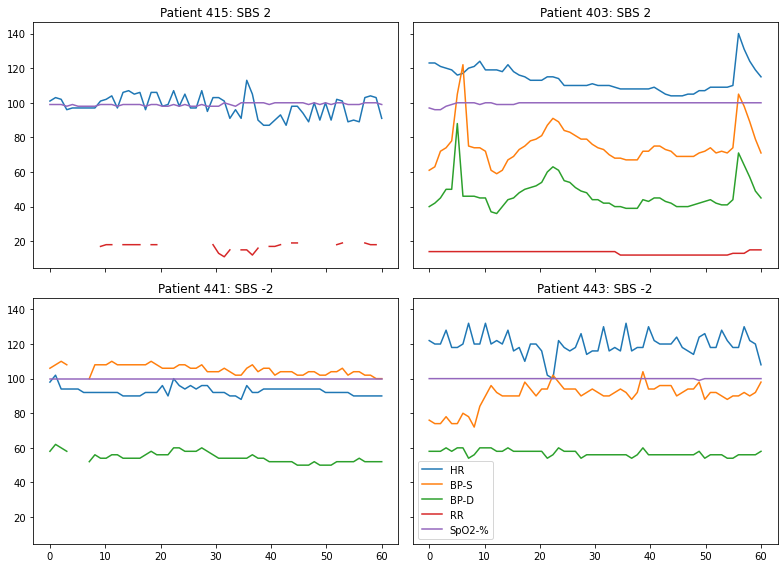

In [59]:
# select patients
samples = [undersed[7], undersed[6], oversed[4], oversed[5]]

# visualize patients
t = np.linspace(0, 60, 60)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(11, 8))
# 'HR', 'BP-S', 'BP-D', 'RR', 'SPO2-%'

for i, ax in enumerate(axs.flatten()):
    p = samples[i]        
    dat = X[p, :, :]

    ax.plot(t, dat[0], label='HR')
    ax.plot(t, dat[1], label='BP-S')
    ax.plot(t, dat[2], label='BP-D')
    ax.plot(t, dat[3], label='RR')
    ax.plot(t, dat[4], label='SpO2-%')
    ax.set_title(f'Patient {p}: SBS {y[p]}')
plt.legend()
plt.tight_layout()
plt.show()

#### ML pipeline

Idea list: https://github.com/danielgy/Paper-list-on-Imbalanced-Time-series-Classification-with-Deep-Learning

In [13]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler, SMOTE

Build test and train sets from data frame.
* Data frame null values are "filled in" with extraneous value of -1
* SBS is on a scale of -3 to +2.  However, class labels can't be negative.  Thus, all SBS score class labels are shifted by 3 to satisfy this.
* Train and test sets are created.
* Class label distribution between train and test set look similar via visual inspection.

In [1]:
# replace missing data with unphysiological value
X = np.nan_to_num(X, nan=-1)

# shift SBS to range from 0 to 6
y += 3

# split by patient instead to reduce bias. 
# n_splits for cross validation
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
split = gss.split(X, y, ids)
train_index, test_index = next(split)

X_train = X[train_index,:,:]
y_train = y[train_index]
X_test = X[test_index,:,:]
y_test = y[test_index]

print(X_train.shape)
print(X_test.shape)

# check class distribution of training and test groups
plt.hist(y_train)
plt.show()
plt.hist(y_test)
# visually, train and test label distribution look similar

NameError: name 'np' is not defined

Normalize data onto 0-1 range for each physiological parameter.
- Another approach is standardization to 0 mean and 1 std, but here we don't expect physiology to fall onto a normal curve
- This is vulnerable to the test distribution being different from the train distribution in terms of minmax. A obvious flaw is that age is strongly correlated to range of heart rate

In [177]:
from numpy import newaxis
minX = np.min(X_train, axis=(0,2)).reshape(3, 1)[newaxis, :, :]
maxX = np.max(X_train, axis=(0,2)).reshape(3, 1)[newaxis, :, :]
X_train = (X_train - minX) / (maxX - minX)

# note the test dataset is standardized to the min/max of the train set
X_test = (X_test - minX) / (maxX - minX)

##### Addressing class imbalance:
Common strategies for class imbalance are random upsampling and downsampling, as well as synthetic upsampling.
- Random downsampling: remove examples from the most common class. This is not preferred here since we do not have too many data points
- Random upsampling: repeating rare classes
- Synthetic upsampling generates synthetic data using available data distribution. We use [SMOTE](https://arxiv.org/pdf/1106.1813.pdf), a highly-cited algorithm
Importantly, upsampling is only done on the training data

However, the results did not fix classification bias. There is also theoretical work suggesting that for strong classifiers, tuning the threshold is better than SMOTE (https://arxiv.org/abs/2201.08528)

(15288, 3, 30)


(array([2548.,    0., 2548.,    0., 2548.,    0., 2548.,    0., 2548.,
        2548.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

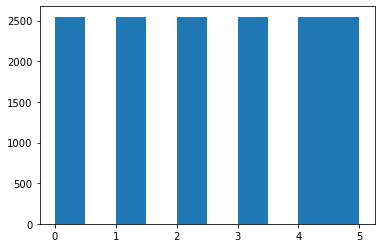

In [129]:
# randomly upsample rare classes
# sampler = RandomOverSampler(random_state=42)

# synthetic upsampling using SMOTE
# sampler = SMOTE()

# samples = X_train.shape[0]
# dims = X_train.shape[1]
# times = X_train.shape[2]

# X_lin = X_train.reshape(samples,-1)
# X_oversample, y_train = sampler.fit_resample(X_lin, y_train)
# X_train = X_oversample.reshape((X_oversample.shape[0], dims, times))

# print(X_train.shape)
# plt.hist(y_train)

### Models

We trained and tested 2 models: TSai and Rocket in combination with XGBoost.  As seen in our output metrics (especially in the confusion matrix), the combination of Rocket and XGBoost performed better than TSai.  Thus, we continued with this model, and worked on refining the various hyperparameters to help improve the model's performance.

#### TSai


https://github.com/timeseriesAI/tsai

In [11]:
from tsai.all import *
my_setup()

os              : Windows-10-10.0.19041-SP0
python          : 3.7.13
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 1
RAM             : 24.0 GB
GPU memory      : N/A


Counts by label: {2: 282, 3: 1031, 4: 125, 5: 167, 1: 54, 0: 4}
Naive Accuracy: 62.00%


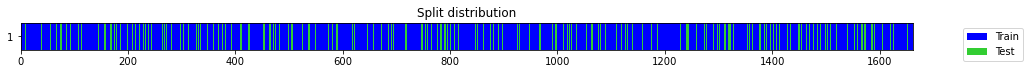

((#1331) [750,1649,1164,1464,785,1272,600,605,1436,1627...],
 (#332) [568,1585,968,331,1026,714,1643,925,1508,1130...])

In [37]:
label_counts = collections.Counter(y_train)

print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

splits = get_splits(y_train, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

In [38]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()

dls = get_ts_dls(X_train, y_train, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
dls.dataset

(#1331) [(TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(5)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(3)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(2)), (TSTensor(vars:5, len:60, device=cpu, dtype=torch.float32), TensorCategory(1))] ...]

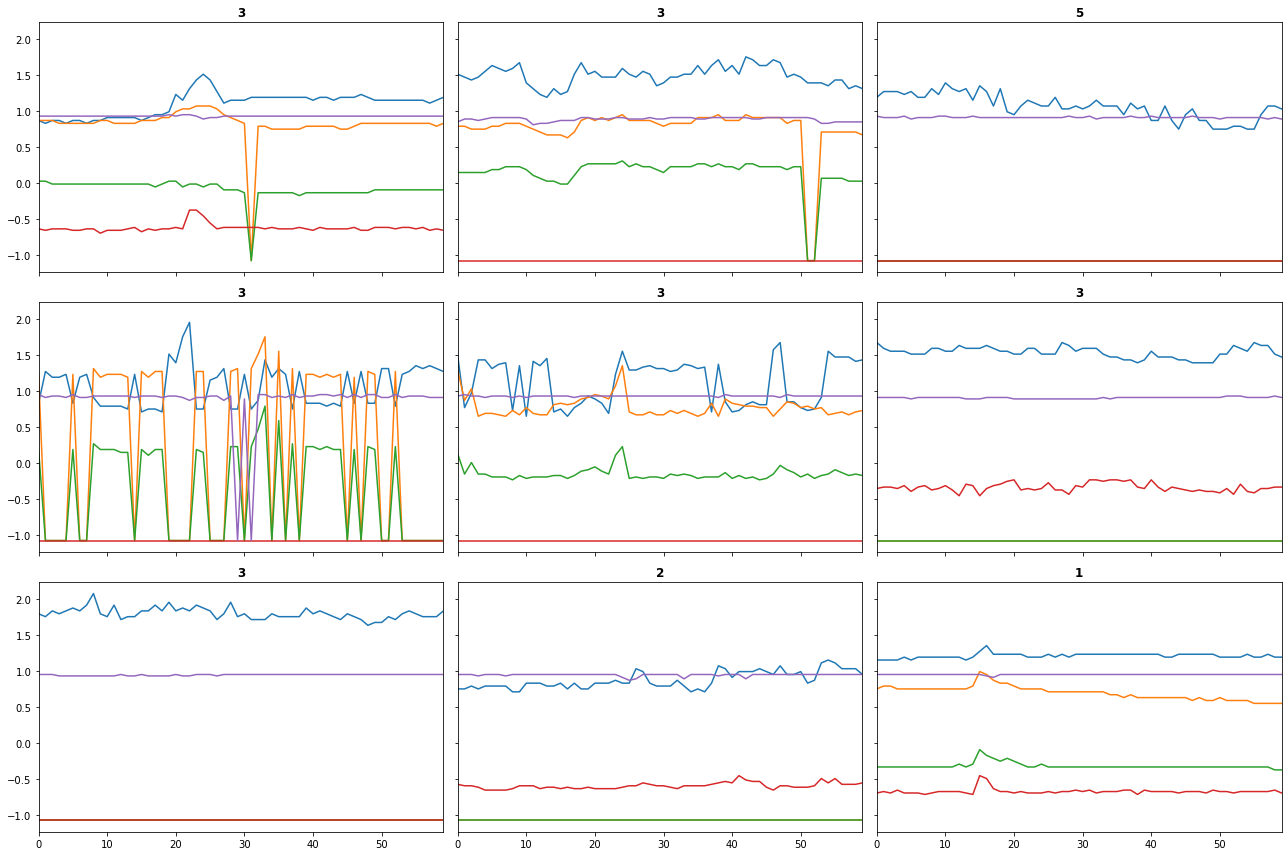

In [39]:
dls.show_batch(sharey=True)

SuggestedLRs(valley=0.0020892962347716093)

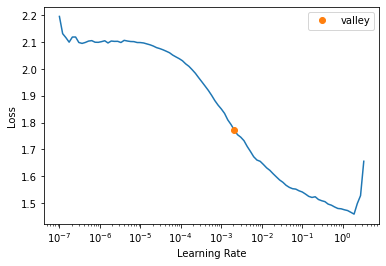

In [40]:
model = build_ts_model(InceptionTimePlus, dls=dls)
learn = Learner(dls, model, metrics=accuracy)

learn.lr_find()

In [47]:
# train
learn = ts_learner(dls, metrics=F1Score, cbs=ShowGraph())
learn.fit_one_cycle(10, lr_max=2e-3)

epoch     train_loss  valid_loss  F1Score   time    


TypeError: Exception occured in `Recorder` when calling event `after_batch`:
	unsupported operand type(s) for *: 'AccumMetric' and 'int'

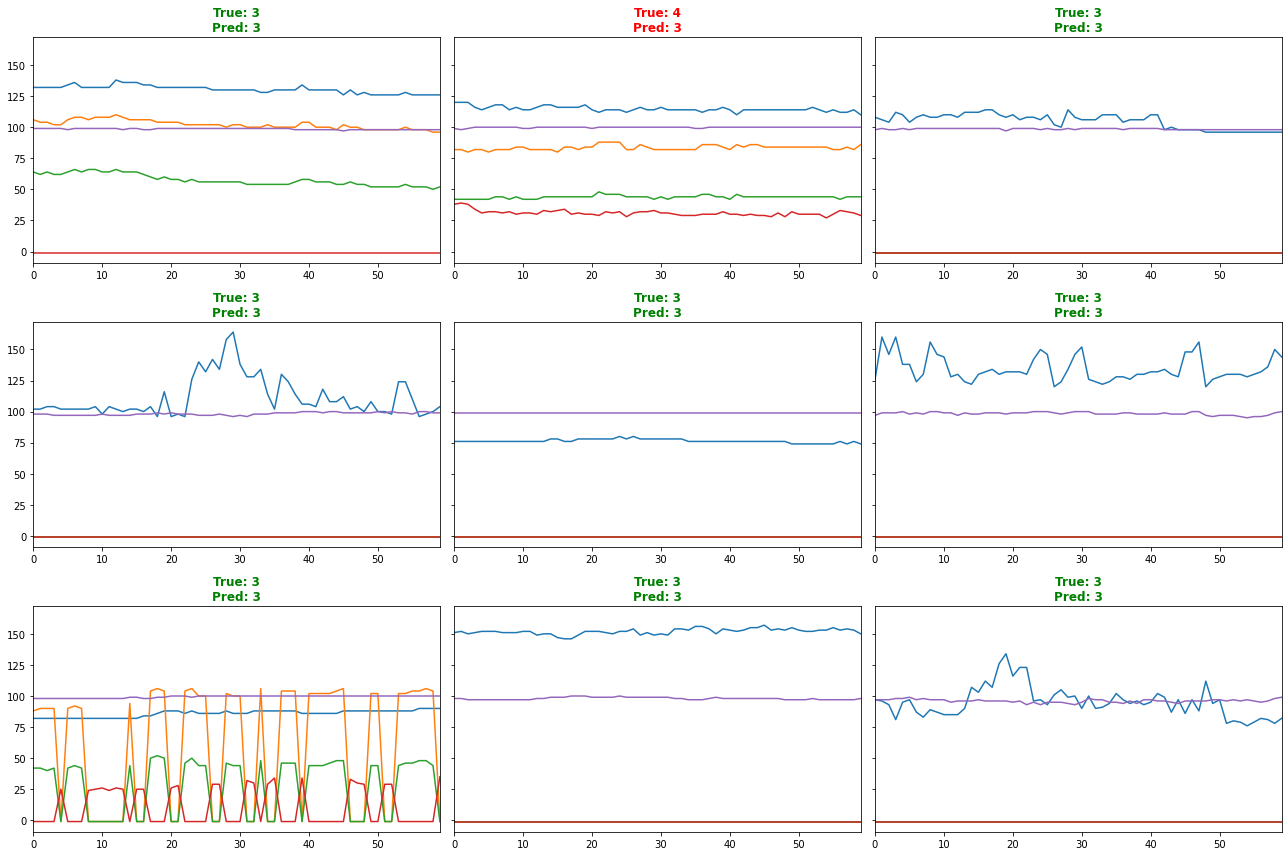

In [43]:
learn.show_results(sharey=True)

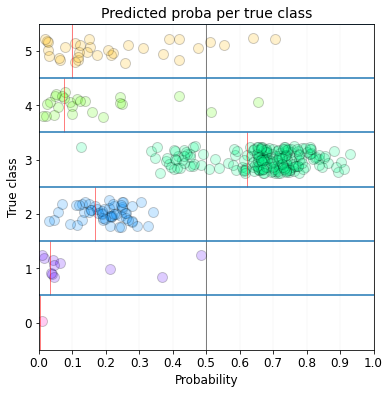

In [44]:
learn.show_probas()

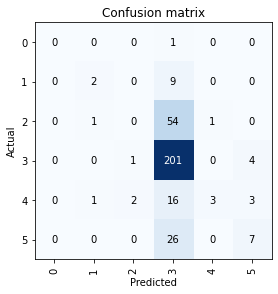

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### ROCKET + XGBoost:
- [Workflow tutorial](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)
- [Hyperparameter list](https://xgboost.readthedocs.io/en/stable/parameter.html)

- [Hyperparameter tuning tutorial (Section 2)](https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663)

An alternative to upsampling is to weigh samples by class rarity

In [178]:
rocket = Rocket()
rocket.fit(X_train)
# transform patient waveform into features using ROCKET
X_train_transform = rocket.transform(X_train)
X_test_transform = rocket.transform(X_test)

In [181]:
# use xgboost classifier
dtrain = xgb.DMatrix(X_train_transform, label=y_train)
dtest = xgb.DMatrix(X_test_transform, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]
evalset = [(X_train_transform, y_train), (X_test_transform, y_test)]

param = {'n_estimators': 15,
         'max_depth': 10, 
         'learning_rate': 0.2,          # try 0.01, 0.1, and 1 first
         'colsample_bytree': 1,
         'subsample': 0.9,
         'gamma': 10,
         'objective': 'multi:softmax', 
         'num_class': 6,
         'eval_metric': 'auc'}

# https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310
class_weight = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(y_train), y=y_train)

# double * to unpack param
model = xgb.XGBClassifier(**param)
model.fit(X_train_transform, y_train, eval_set=evalset)
# bst = xgb.train(param, dtrain, num_round, evallist)

# observe that as train AUC increase, eval AUC decrease
# this indicates model overfitting (or the data is fundamentally different)
# more model tuning is required

[0]	validation_0-auc:0.83505	validation_1-auc:0.57232
[1]	validation_0-auc:0.87962	validation_1-auc:0.59065
[2]	validation_0-auc:0.89504	validation_1-auc:0.60433
[3]	validation_0-auc:0.91117	validation_1-auc:0.61132
[4]	validation_0-auc:0.91998	validation_1-auc:0.61832
[5]	validation_0-auc:0.92222	validation_1-auc:0.61946
[6]	validation_0-auc:0.92585	validation_1-auc:0.62570
[7]	validation_0-auc:0.92840	validation_1-auc:0.62551
[8]	validation_0-auc:0.93166	validation_1-auc:0.62545
[9]	validation_0-auc:0.93310	validation_1-auc:0.62950
[10]	validation_0-auc:0.93738	validation_1-auc:0.63211
[11]	validation_0-auc:0.93849	validation_1-auc:0.63298
[12]	validation_0-auc:0.94082	validation_1-auc:0.63169
[13]	validation_0-auc:0.94213	validation_1-auc:0.63193
[14]	validation_0-auc:0.94531	validation_1-auc:0.63290


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=10, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=0,
              num_class=6, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, ...)

Accuracy: 0.579


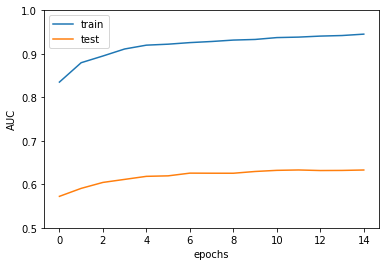

In [184]:
# evaluate performance
yhat = model.predict(X_test_transform)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# we can save this into a list, or plot it

# plot learning curves
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
plt.xlabel('epochs')
plt.ylabel('AUC')
# plot from 0 to 1
plt.ylim(0.5,1)
# show the legend
plt.legend()
# show the plot
plt.show()

#### Evaluation: Confusion Matrix

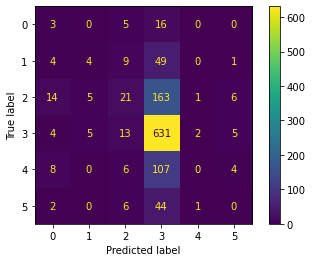

In [185]:
y_class = np.unique(y)
cm = confusion_matrix(y_test, yhat, labels=y_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_class)
disp.plot()